In [5]:
# Cell 1: Data Loading and Preprocessing
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import gc
from pathlib import Path

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

import lime
import lime.lime_image
import shap

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define constants
DATA_DIR = "/kaggle/input/brain-tumor-mri-dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
TEST_DIR = os.path.join(DATA_DIR, "Testing")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
CLASSES = sorted([item.name for item in Path(TRAIN_DIR).iterdir() if item.is_dir()])
NUM_CLASSES = len(CLASSES)
print(f"Classes found: {CLASSES}")

# Using ImageDataGenerator for loading and potential augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Convert generators to tf.data.Dataset
def gen_to_dataset(generator):
    output_signature = (
        tf.TensorSpec(shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float32)
    )
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=output_signature
    )
    return dataset

# Create datasets and apply repeat
train_dataset = gen_to_dataset(train_generator).repeat().prefetch(tf.data.AUTOTUNE)
test_dataset = gen_to_dataset(test_generator).repeat().prefetch(tf.data.AUTOTUNE)

# Get labels for evaluation
y_train_encoded = train_generator.classes
y_test_encoded = test_generator.classes

# Check class distribution
class_counts = pd.Series(train_generator.classes).value_counts()
print(class_counts)

print(f"Found {train_generator.samples} training images belonging to {NUM_CLASSES} classes.")
print(f"Found {test_generator.samples} testing images belonging to {NUM_CLASSES} classes.")

Classes found: ['glioma', 'meningioma', 'notumor', 'pituitary']
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
2    1595
3    1457
1    1339
0    1321
Name: count, dtype: int64
Found 5712 training images belonging to 4 classes.
Found 1311 testing images belonging to 4 classes.


In [6]:
# Cell 2: Classification Model (RepOpt-B1)
import tensorflow as tf
from tensorflow.keras import layers, models

def repopt_block(x, filters, num_layers, kernel_size=3, strides=1):
    """RepOpt block with simplified re-parameterization."""
    for _ in range(num_layers):
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
        x = layers.BatchNormalization()(x)  # Approximation of CSLA
        x = layers.ReLU()(x)
    return x

def repopt_b1(input_shape=(224, 224, 3), num_classes=4):
    """RepOpt-B1 classification model."""
    inputs = layers.Input(shape=input_shape)

    # Layer 1: 1 RepOpt block
    x = repopt_block(inputs, 64, num_layers=1)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 2: 4 RepOpt blocks
    x = repopt_block(x, 128, num_layers=4)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 3: 6 RepOpt blocks
    x = repopt_block(x, 256, num_layers=6)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 4: 16 RepOpt blocks
    x = repopt_block(x, 512, num_layers=16)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 5: Atrous convolution layers
    x = layers.Conv2D(512, 3, padding='same', dilation_rate=2)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(512, 3, padding='same', dilation_rate=4)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(512, 3, padding='same', dilation_rate=8, name='last_conv')(x)
    x = layers.ReLU()(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Output
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

# Initialize and compile classification model
cls_model = repopt_b1(num_classes=NUM_CLASSES)
cls_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [19]:
# Cell 3: Explainability Module (Grad-CAM++)
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def grad_cam_plus_plus(model, img_array, layer_name, class_idx):
    """Grad-CAM++ implementation."""
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    # Ensure conv_outputs is 4D
    if len(conv_outputs.shape) != 4:
        raise ValueError(f"Expected 4D output from layer {layer_name}, got shape {conv_outputs.shape}")

    grads = tape.gradient(loss, conv_outputs)
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    grads = grads[0]  # Remove batch dimension

    # Debug: Check shapes and values
    print(f"conv_outputs shape: {conv_outputs.shape}, min: {tf.reduce_min(conv_outputs).numpy()}, max: {tf.reduce_max(conv_outputs).numpy()}")
    print(f"grads shape: {grads.shape}, min: {tf.reduce_min(grads).numpy()}, max: {tf.reduce_max(grads).numpy()}")

    # Grad-CAM++ weights
    first_derivative = tf.exp(loss) * grads
    second_derivative = tf.exp(loss) * grads * grads
    third_derivative = tf.exp(loss) * grads * grads * grads

    # Compute global sum and alpha_kc
    global_sum = tf.reduce_mean(conv_outputs, axis=(0, 1), keepdims=True)
    denominator = 2 * tf.reduce_mean(first_derivative, axis=(0, 1)) + \
                  tf.reduce_mean(third_derivative, axis=(0, 1)) * global_sum
    # Avoid division by zero
    denominator = tf.where(denominator == 0, tf.ones_like(denominator) * 1e-10, denominator)
    alpha_kc = tf.reduce_mean(second_derivative, axis=(0, 1)) / denominator

    # Compute weights
    weights = tf.reduce_mean(alpha_kc * tf.nn.relu(first_derivative), axis=(0, 1))
    
    # Compute CAM
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)
    cam = tf.nn.relu(cam)
    
    # Normalize CAM
    cam_max = tf.reduce_max(cam)
    cam = tf.where(cam_max != 0, cam / (cam_max + 1e-10), cam)
    
    # Clip CAM to [0, 1] to avoid invalid values
    cam = tf.clip_by_value(cam, 0.0, 1.0)
    
    # Resize to input image size
    cam = tf.image.resize(cam[tf.newaxis, ..., tf.newaxis], (224, 224))[0, ..., 0]
    
    # Debug: Check CAM values
    cam_np = cam.numpy()
    print(f"CAM min: {cam_np.min()}, max: {cam_np.max()}, has_nan: {np.any(np.isnan(cam_np))}")

    return cam_np

def visualize_cam(model, img_array, layer_name, class_idx, class_names, save_path=None):
    """Visualize Grad-CAM++ heatmap."""
    try:
        cam = grad_cam_plus_plus(model, img_array, layer_name, class_idx)
    except ValueError as e:
        print(f"Error generating Grad-CAM++: {e}")
        return

    # Ensure cam is valid before casting
    if np.any(np.isnan(cam)) or np.any(np.isinf(cam)):
        print(f"Warning: Invalid values in CAM for class {class_names[class_idx]}")
        return
    
    cam = np.uint8(255 * cam)
    cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    
    img = img_array[0]
    img = np.uint8(255 * (img - img.min()) / (img.max() - img.min()))
    
    superimposed_img = cam * 0.4 + img * 0.6
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM++: {class_names[class_idx]}")
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

Epoch 1/20


I0000 00:00:1746493996.535111     318 service.cc:148] XLA service 0x7e65f4094580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746493996.535183     318 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746493996.535189     318 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746493997.758767     318 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-06 01:13:35.278232: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[512,2048,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,512,3,3]{3,2,1,0}, f32[2048,512,2,2]{3,2,1,0}), window={size=2x2 pad=1_1x1_1 rhs_reversal=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"op

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4330 - loss: 1.1507
Epoch 1: val_loss improved from inf to 1.89321, saving model to /kaggle/working/repopt_b1_best.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.4335 - loss: 1.1500 - val_accuracy: 0.2102 - val_loss: 1.8932
Epoch 2/20


2025-05-06 01:19:14.142194: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[512,1024,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,512,3,3]{3,2,1,0}, f32[1024,512,2,2]{3,2,1,0}), window={size=2x2 pad=1_1x1_1 rhs_reversal=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-06 01:19:14.310147: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.168156348s
Trying algorithm eng4{} for conv (f32[512,1024,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,512,3,3]{3,2,1,0}, f32[1024,512,2,2]{3,2,1,0}), window={size=2x2 pad=1_1x1_1 rhs_reversal=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_b

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6847 - loss: 0.7836
Epoch 2: val_loss did not improve from 1.89321
178/178 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.6847 - loss: 0.7836 - val_accuracy: 0.3143 - val_loss: 7.4316
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7402 - loss: 0.6973
Epoch 3: val_loss improved from 1.89321 to 1.12476, saving model to /kaggle/working/repopt_b1_best.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.7402 - loss: 0.6971 - val_accuracy: 0.6013 - val_loss: 1.1248
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8001 - loss: 0.5679
Epoch 4: val_loss did not improve from 1.12476
178/178 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.8001 - loss: 0.5678 - val_accuracy: 0.5692 - val_loss: 1.9183
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8231 - loss: 0.4934
Epoch 5: val_loss improved from 1.12476 to 0.54789, saving model to /kaggle/working/repopt_b1_best.keras
178/178 ━━━━━

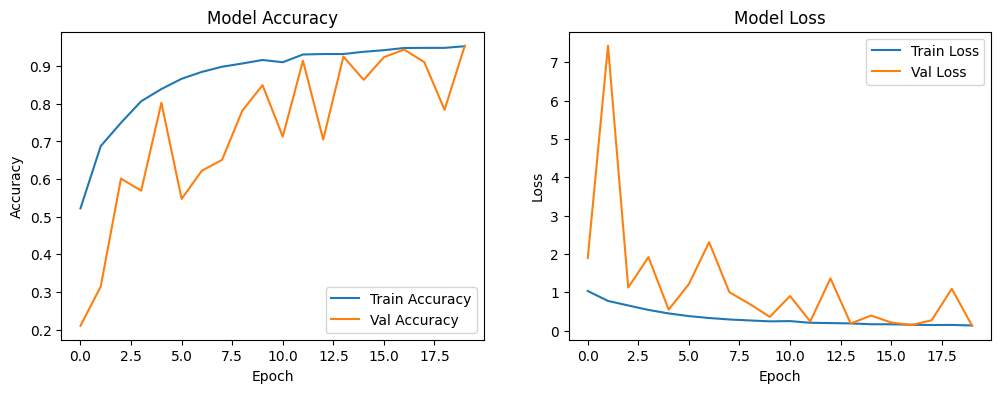

In [9]:
# Cell 4: Train Classification Model with Stopping Criteria
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = test_generator.samples // BATCH_SIZE

# Compute class weights for imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict = dict(enumerate(class_weights))

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs without improvement
    restore_best_weights=True,  # Restore weights from the best epoch
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    '/kaggle/working/repopt_b1_best.keras',  # Changed to .keras extension
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = cls_model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=20,  # Maximum epochs
    validation_data=test_dataset,
    validation_steps=validation_steps,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/training_history.png')
plt.show()

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.94      0.96       300
  meningioma       0.94      0.88      0.91       306
     notumor       0.95      1.00      0.97       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.95      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



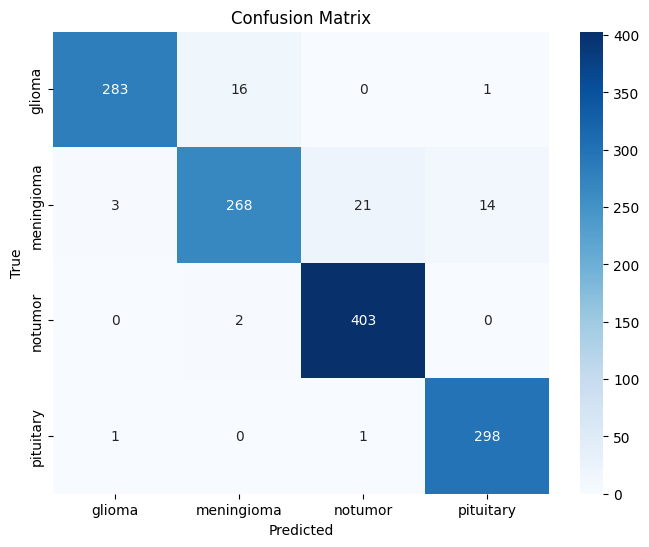

In [15]:
# Cell 5: Evaluate Classification Model
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Collect predictions and true labels for the entire test dataset
test_generator.reset()  # Reset generator to start from the beginning
pred_labels = []
true_labels = []
steps = test_generator.samples // BATCH_SIZE + (1 if test_generator.samples % BATCH_SIZE else 0)

for _ in range(steps):
    images, labels = next(test_generator)
    preds = cls_model.predict(images, verbose=0)
    pred_labels.append(np.argmax(preds, axis=1))
    true_labels.append(np.argmax(labels, axis=1))

# Flatten lists
pred_classes = np.concatenate(pred_labels)
true_classes = np.concatenate(true_labels)

# Classification report
print("Classification Report:")
print(classification_report(true_classes, pred_classes, target_names=CLASSES))

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Generating heatmap for sample 1, predicted class: glioma
conv_outputs shape: (14, 14, 512), min: -6.582876205444336, max: 8.538816452026367
grads shape: (14, 14, 512), min: -4.239410766881946e-10, max: 3.910936574591517e-10
CAM min: 0.0, max: 1.355401337832518e-07, has_nan: False


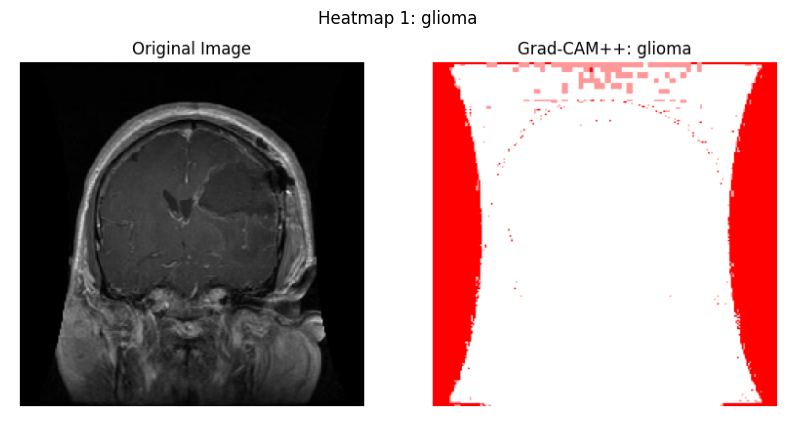

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Generating heatmap for sample 2, predicted class: glioma
conv_outputs shape: (14, 14, 512), min: -5.331333160400391, max: 7.461065292358398
grads shape: (14, 14, 512), min: -2.5073507714523657e-09, max: 2.3620092548526372e-09
CAM min: 0.0, max: 4.359415470389649e-06, has_nan: False


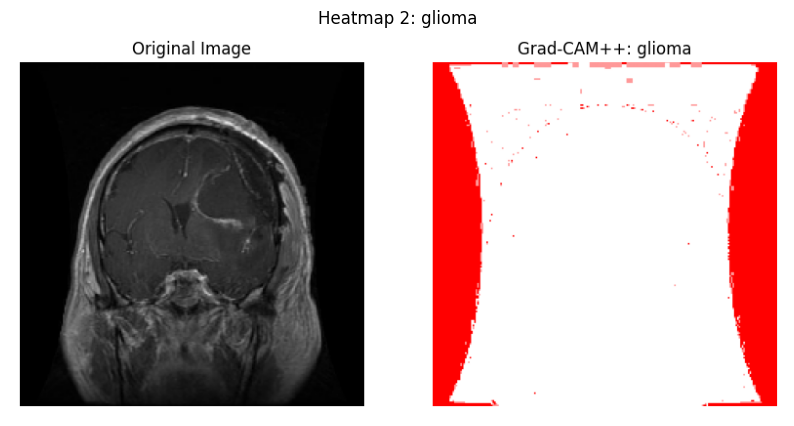

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Generating heatmap for sample 3, predicted class: glioma
conv_outputs shape: (14, 14, 512), min: -5.581611156463623, max: 7.361455917358398
grads shape: (14, 14, 512), min: -5.885501419555794e-09, max: 5.455532470222124e-09
CAM min: 0.0, max: 2.129522181348875e-05, has_nan: False


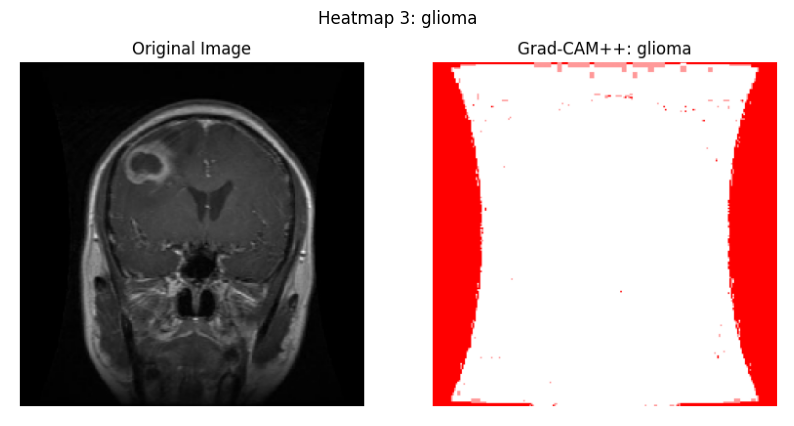

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Generating heatmap for sample 4, predicted class: glioma
conv_outputs shape: (14, 14, 512), min: -5.905457973480225, max: 7.325582504272461
grads shape: (14, 14, 512), min: -1.031961094355438e-08, max: 9.88304016402708e-09
CAM min: 0.0, max: 7.236129022203386e-05, has_nan: False


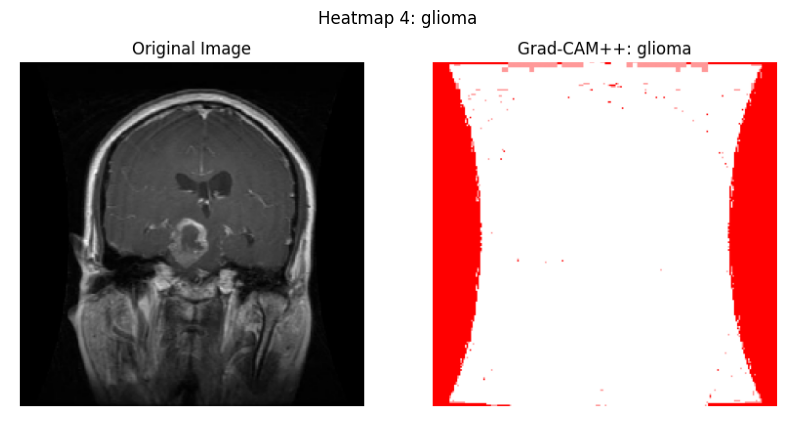

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Generating heatmap for sample 5, predicted class: glioma
conv_outputs shape: (14, 14, 512), min: -7.004644870758057, max: 9.010272979736328
grads shape: (14, 14, 512), min: -2.9346206020797183e-10, max: 2.622302930355147e-10
CAM min: 0.0, max: 6.397217333642402e-08, has_nan: False


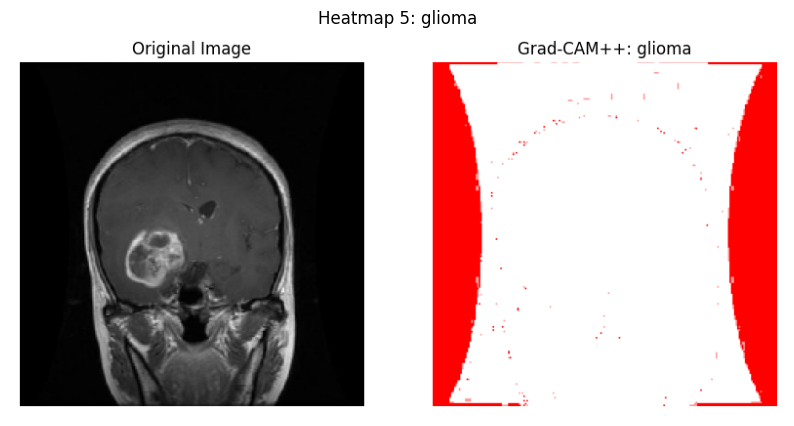

In [20]:
# Cell 6: Visualize Grad-CAM++ Heatmaps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

num_samples = 5
test_images, test_labels = next(test_generator)
for i in range(min(num_samples, len(test_images))):
    img_array = test_images[i:i+1]
    pred = cls_model.predict(img_array)
    class_idx = np.argmax(pred[0])
    save_path = f'/kaggle/working/heatmap_{i}.png'
    print(f"Generating heatmap for sample {i+1}, predicted class: {CLASSES[class_idx]}")
    visualize_cam(cls_model, img_array, 'last_conv', class_idx, CLASSES, save_path=save_path)
    
    # Display the saved heatmap
    if os.path.exists(save_path):
        img = mpimg.imread(save_path)
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.title(f"Heatmap {i+1}: {CLASSES[class_idx]}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Heatmap not saved at {save_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Generating Grad-CAM for sample 1, predicted class: glioma
Grad-CAM min: 5.4028980230214074e-05, max: 0.9977600574493408, has_nan: False


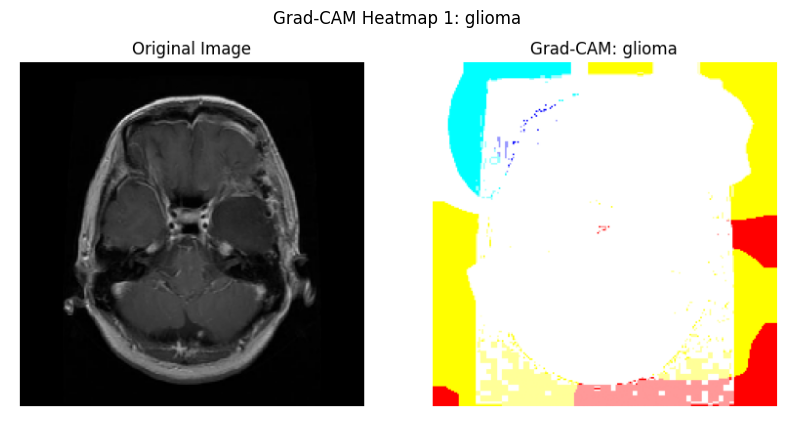

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Generating Grad-CAM for sample 2, predicted class: glioma
Grad-CAM min: 0.053803589195013046, max: 0.9988736510276794, has_nan: False


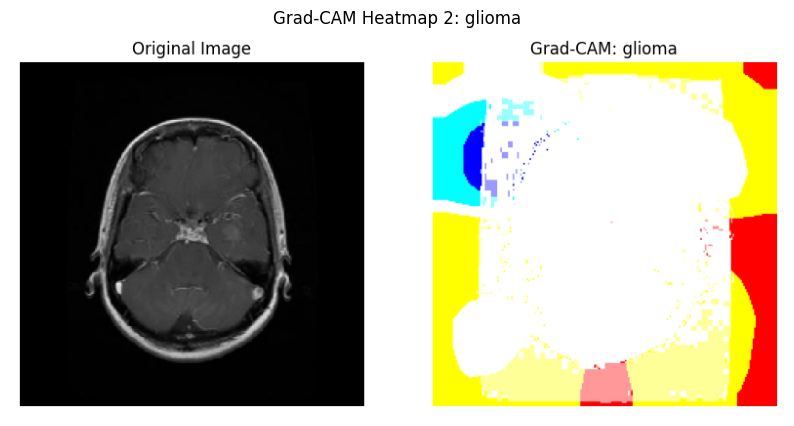

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Generating Grad-CAM for sample 3, predicted class: glioma
Grad-CAM min: 0.06486520916223526, max: 0.9970375299453735, has_nan: False


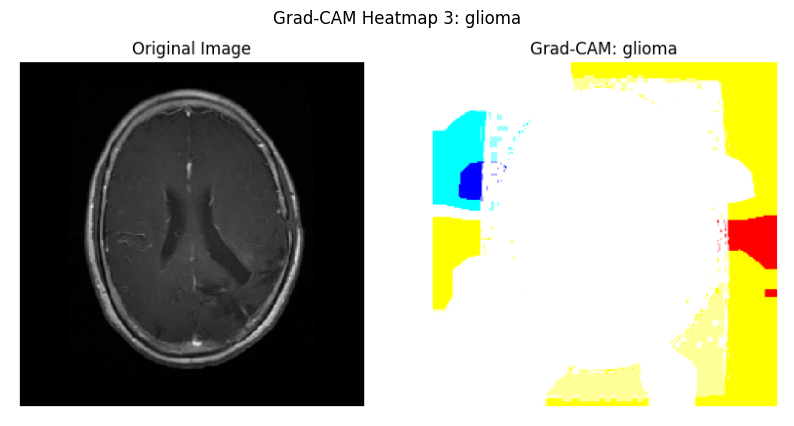

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Generating Grad-CAM for sample 4, predicted class: glioma
Grad-CAM min: 0.0, max: 0.9981862306594849, has_nan: False


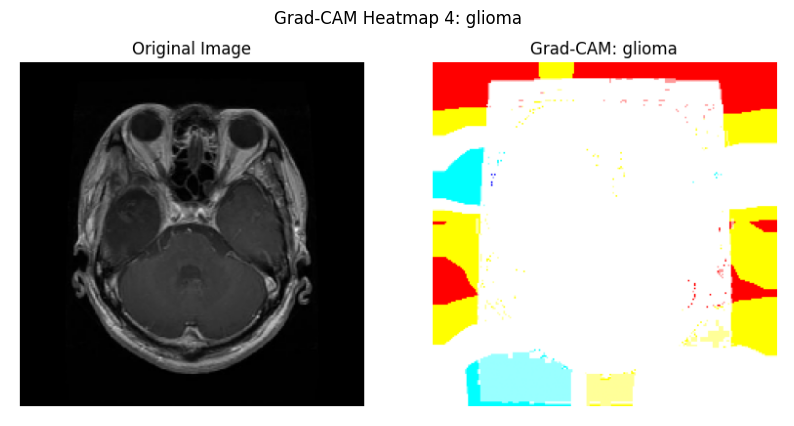

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Generating Grad-CAM for sample 5, predicted class: glioma
Grad-CAM min: 0.05320323631167412, max: 0.9953905344009399, has_nan: False


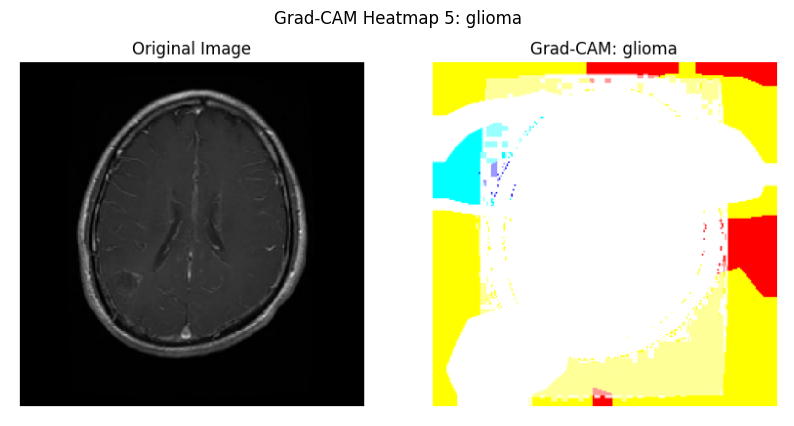

In [21]:
# Cell 7: Visualize Normal Grad-CAM Heatmaps
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def grad_cam(model, img_array, layer_name, class_idx):
    """Grad-CAM implementation."""
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    # Ensure conv_outputs is 4D
    if len(conv_outputs.shape) != 4:
        raise ValueError(f"Expected 4D output from layer {layer_name}, got shape {conv_outputs.shape}")

    grads = tape.gradient(loss, conv_outputs)
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    grads = grads[0]  # Remove batch dimension

    # Compute the guided gradients
    weights = tf.reduce_mean(grads, axis=(0, 1))  # Average gradients spatially
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)
    
    # Apply ReLU and normalize
    cam = tf.nn.relu(cam)
    cam_max = tf.reduce_max(cam)
    cam = tf.where(cam_max != 0, cam / (cam_max + 1e-10), cam)
    
    # Clip to [0, 1]
    cam = tf.clip_by_value(cam, 0.0, 1.0)
    
    # Resize to input image size
    cam = tf.image.resize(cam[tf.newaxis, ..., tf.newaxis], (224, 224))[0, ..., 0]
    
    # Debug: Check CAM values
    cam_np = cam.numpy()
    print(f"Grad-CAM min: {cam_np.min()}, max: {cam_np.max()}, has_nan: {np.any(np.isnan(cam_np))}")
    
    return cam_np

def visualize_grad_cam(model, img_array, layer_name, class_idx, class_names, save_path=None):
    """Visualize Grad-CAM heatmap (reuses visualize_cam logic)."""
    try:
        cam = grad_cam(model, img_array, layer_name, class_idx)
    except ValueError as e:
        print(f"Error generating Grad-CAM: {e}")
        return

    # Ensure cam is valid before casting
    if np.any(np.isnan(cam)) or np.any(np.isinf(cam)):
        print(f"Warning: Invalid values in CAM for class {class_names[class_idx]}")
        return
    
    cam = np.uint8(255 * cam)
    cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    
    img = img_array[0]
    img = np.uint8(255 * (img - img.min()) / (img.max() - img.min()))
    
    superimposed_img = cam * 0.4 + img * 0.6
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM: {class_names[class_idx]}")
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

# Generate and display Grad-CAM heatmaps
num_samples = 5
test_images, test_labels = next(test_generator)
for i in range(min(num_samples, len(test_images))):
    img_array = test_images[i:i+1]
    pred = cls_model.predict(img_array)
    class_idx = np.argmax(pred[0])
    save_path = f'/kaggle/working/gradcam_{i}.png'
    print(f"Generating Grad-CAM for sample {i+1}, predicted class: {CLASSES[class_idx]}")
    visualize_grad_cam(cls_model, img_array, 'last_conv', class_idx, CLASSES, save_path=save_path)
    
    # Display the saved heatmap
    if os.path.exists(save_path):
        img = mpimg.imread(save_path)
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.title(f"Grad-CAM Heatmap {i+1}: {CLASSES[class_idx]}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Grad-CAM heatmap not saved at {save_path}")

Generating LIME explanation for sample 1, predicted class: glioma


  0%|          | 0/1000 [00:00<?, ?it/s]

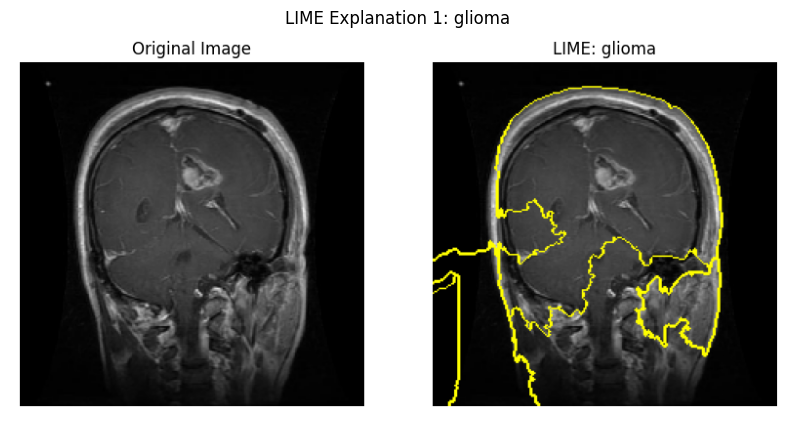

Generating LIME explanation for sample 2, predicted class: glioma


  0%|          | 0/1000 [00:00<?, ?it/s]

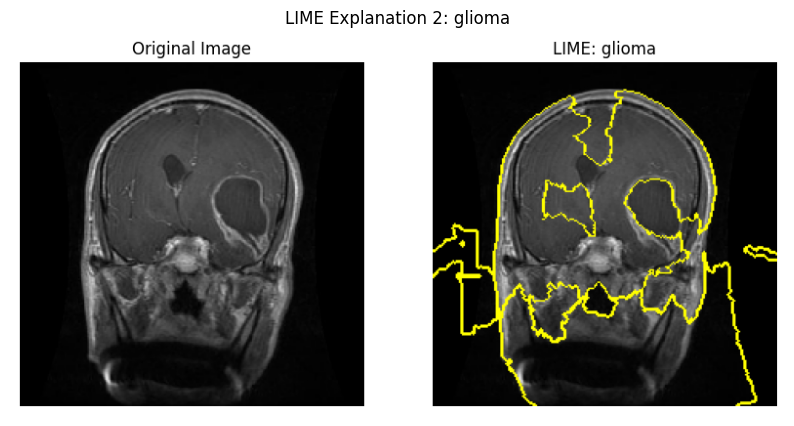

Generating LIME explanation for sample 3, predicted class: glioma


  0%|          | 0/1000 [00:00<?, ?it/s]

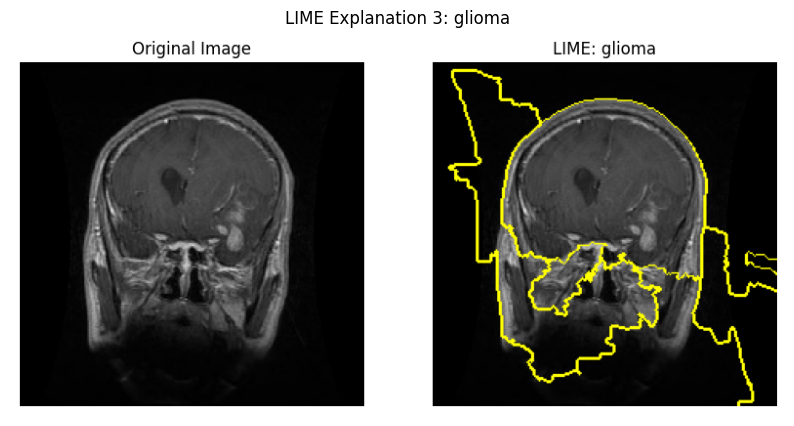

Generating LIME explanation for sample 4, predicted class: glioma


  0%|          | 0/1000 [00:00<?, ?it/s]

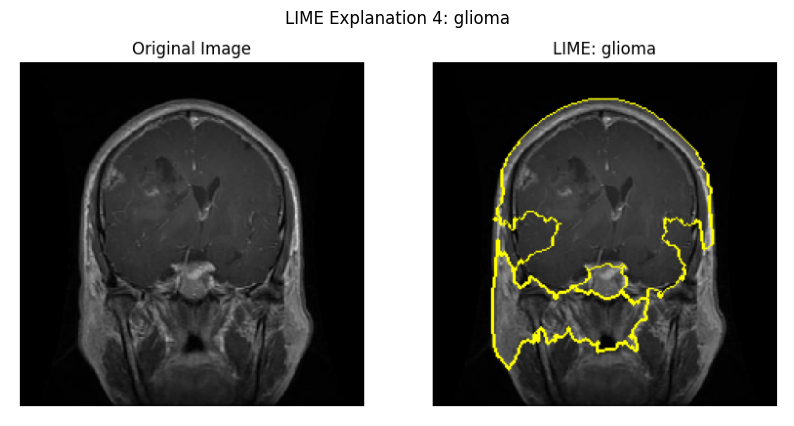

Generating LIME explanation for sample 5, predicted class: glioma


  0%|          | 0/1000 [00:00<?, ?it/s]

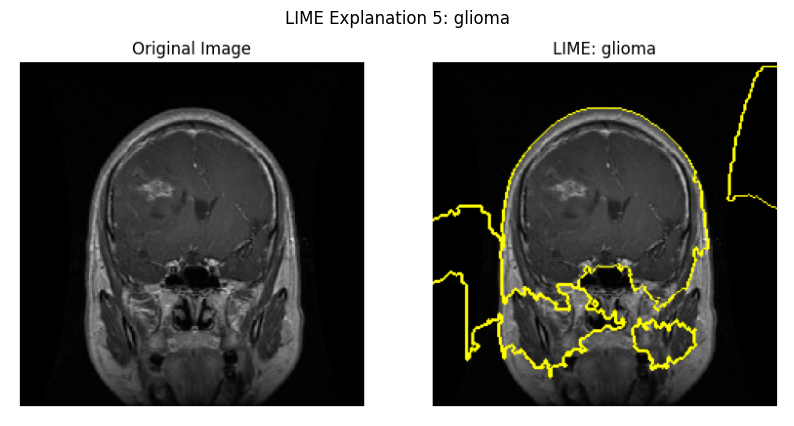

In [22]:
# Cell 8: Visualize LIME Explanations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Define prediction function for LIME
def predict_fn(images):
    """Prediction function for LIME, expects images in [0, 1] range."""
    # Ensure images are in the correct format for cls_model
    images = np.array(images)
    if images.shape[-1] == 4:  # Remove alpha channel if present
        images = images[..., :3]
    preds = cls_model.predict(images, verbose=0)
    return preds

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Generate and display LIME explanations
num_samples = 5
test_images, test_labels = next(test_generator)
for i in range(min(num_samples, len(test_images))):
    img_array = test_images[i]  # Shape: (224, 224, 3), values in [0, 1]
    pred = cls_model.predict(img_array[np.newaxis, ...], verbose=0)
    class_idx = np.argmax(pred[0])
    print(f"Generating LIME explanation for sample {i+1}, predicted class: {CLASSES[class_idx]}")
    
    # Generate LIME explanation
    explanation = explainer.explain_instance(
        img_array,
        predict_fn,
        top_labels=NUM_CLASSES,
        hide_color=0,  # Mask with black
        num_samples=1000,  # Number of perturbations
        random_seed=42
    )
    
    # Get LIME visualization for the predicted class
    temp, mask = explanation.get_image_and_mask(
        class_idx,
        positive_only=False,  # Show both positive and negative contributions
        num_features=10,  # Number of superpixels to highlight
        hide_rest=False,  # Show the full image
        min_weight=0.0  # Include all features above this threshold
    )
    
    # Create visualization
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(img_array, mask))
    plt.title(f"LIME: {CLASSES[class_idx]}")
    plt.axis('off')
    
    # Save visualization
    save_path = f'/kaggle/working/lime_{i}.png'
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()
    
    # Display the saved visualization
    if os.path.exists(save_path):
        img = mpimg.imread(save_path)
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.title(f"LIME Explanation {i+1}: {CLASSES[class_idx]}")
        plt.axis('off')
        plt.show()
    else:
        print(f"LIME visualization not saved at {save_path}")